In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [16]:
movies = pd.read_parquet("../tmbd_exports/tmbd_5000_api-call_merged.parquet")
movies.shape

(6068, 19)

In [3]:
movies.head()

,budget,genres,homepage,movie_id,keywords,original_language,original_title,overview,popularity,release_date,revenue,runtime,status,tagline,title,vote_average,vote_count,cast,director
0,237000000,"Action, Adventure, Fantasy, Science Fiction",http://www.avatarmovie.com/,19995,"culture clash, future, space war, space colony...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,2009-12-10,2787965087,162.0,Released,Enter the World of Pandora.,Avatar,7.2,11800,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",James Cameron
1,300000000,"Adventure, Fantasy, Action",http://disney.go.com/disneypictures/pirates/,285,"ocean, drug abuse, exotic island, east india t...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,2007-05-19,961000000,169.0,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"Johnny Depp, Orlando Bloom, Keira Knightley, S...",Gore Verbinski
2,245000000,"Action, Adventure, Crime",http://www.sonypictures.com/movies/spectre/,206647,"spy, based on novel, secret agent, sequel, mi6",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,2015-10-26,880674609,148.0,Released,A Plan No One Escapes,Spectre,6.3,4466,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra...",Sam Mendes
3,250000000,"Action, Crime, Drama, Thriller",http://www.thedarkknightrises.com/,49026,"dc comics, crime fighter, terrorist, secret id...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,2012-07-16,1084939099,165.0,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"Christian Bale, Michael Caine, Gary Oldman, An...",Christopher Nolan
4,260000000,"Action, Adventure, Science Fiction",http://movies.disney.com/john-carter,49529,"based on novel, mars, medallion, space travel,...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,2012-03-07,284139100,132.0,Released,"Lost in our world, found in another.",John Carter,6.1,2124,"Taylor Kitsch, Lynn Collins, Samantha Morton, ...",Andrew Stanton


<class 'matplotlib.axes._axes.Axes'>


Text(0.5, 1.0, 'Verteilung der Bewertungspunkte')

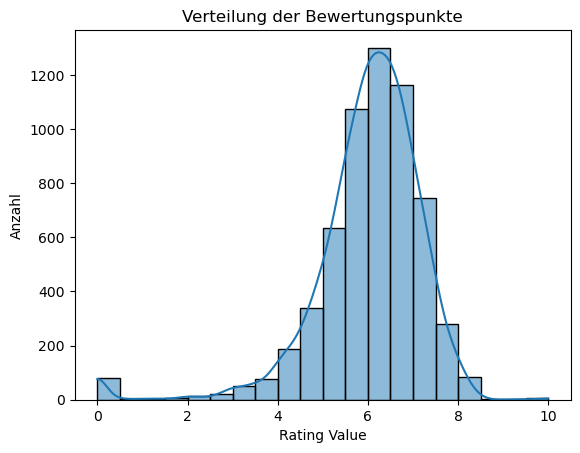

In [4]:
# Histogramm for movies data frame: vote average not optimized
grfk = sns.histplot(movies["vote_average"].astype(float), bins=20, kde=True)

# Prüfe, ob grfk wirklich ein Axes-Objekt ist
print(type(grfk))  # Sollte <class 'matplotlib.axes._axes.Axes'> ausgeben

grfk.set_xlabel("Rating Value")  
grfk.set_ylabel("Anzahl")        
grfk.set_title("Verteilung der Bewertungspunkte")  


### Function weighted_rating_threshold takes a dataframe and returns a data frame. <br> The returned data frame consist of movies with enough votes.

In [5]:
def weighted_rating_threshold(data_frame, qntl): 
    
    if not {"vote_average", "vote_count"}.issubset(data_frame.columns):
        raise ValueError("Die Spalten 'vote_average' und 'vote_count' fehlen im DataFrame!")
        
    m = data_frame["vote_count"].quantile(qntl)
    C = data_frame["vote_average"].mean()
    
    q_movies = data_frame.loc[data_frame["vote_count"] >= m].copy()
   
    def weighted_rating(q_movs, m=m, C=C):
        R = q_movs["vote_average"]
        v = q_movs["vote_count"]
        return (v/(v+m) * R) + (m/(m+v) * C)

    q_movies['weighted_rating'] = q_movies.apply(weighted_rating, axis=1)    
    return q_movies

In [23]:
# weighted_rating_threshold takes a dataframe and a float as qunatile value, like 0.75
q_movies = weighted_rating_threshold(movies, 0.9)
# Sorting and "re-indexing". Reset index to be in sync with consin-matrix
q_movies = q_movies.sort_values(by = "weighted_rating", ascending=False).reset_index(drop=True)

# Take column title to the first position

first_column = q_movies.pop("title")
q_movies.insert(0, 'title', first_column)
q_movies.shape

(607, 20)

<class 'matplotlib.axes._axes.Axes'>


Text(0.5, 1.0, 'Verteilung der Bewertungspunkte')

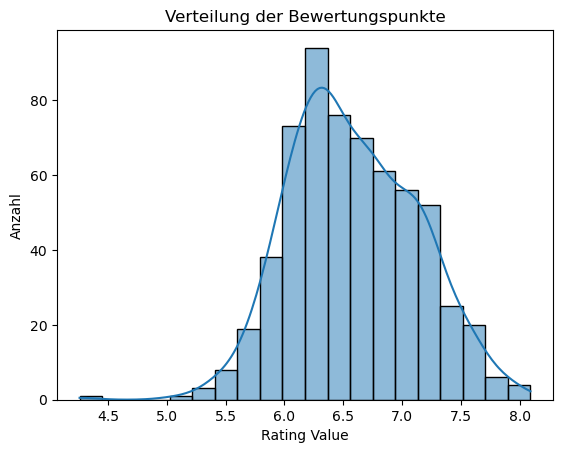

In [24]:
# Histogramm for movies data frame: vote average not optimized
grfk = sns.histplot(q_movies["weighted_rating"].astype(float), bins=20, kde=True)

# Prüfe, ob grfk wirklich ein Axes-Objekt ist
print(type(grfk))  # Sollte <class 'matplotlib.axes._axes.Axes'> ausgeben

grfk.set_xlabel("Rating Value")  
grfk.set_ylabel("Anzahl")        
grfk.set_title("Verteilung der Bewertungspunkte")  


In [25]:
q_movies.to_parquet("../tmbd_exports/quality_movs_weighted_rating.parquet")